# 🎓 Sistema de Recomendação de Conteúdo Educacional

Este notebook apresenta a **validação técnica** do modelo de *Filtros Colaborativos (SVD)*, desenvolvido como requisito do **Estágio Supervisionado III**.

O objetivo é demonstrar o processo completo de construção e validação do modelo em um **dataset de larga escala**, preparando-o para ser integrado a uma aplicação interativa.

Serão abordadas as seguintes etapas:

- **Configuração do ambiente**  
- **Treinamento do algoritmo**  
- **Avaliação de performance**  
- **Validação Cruzada (Cross-Validation)**  

---

## 1️⃣ Configuração do Ambiente e Dependências

A célula a seguir prepara o ambiente de execução, importando todas as bibliotecas essenciais ao projeto, organizadas por finalidade:

- **Utilitários e Bibliotecas Padrão:** `time`, `pickle`  
- **Manipulação de Dados:** `pandas`, `numpy`  
- **Visualização de Dados:** `matplotlib`, `seaborn`  
- **Machine Learning (Recomendação):** `surprise`  

---


In [1]:
# --- CÉLULA 01: CONFIGURAÇÃO DE AMBIENTE E IMPORTAÇÕES ---

# --- Imports Padrão e Sistema ---
import os # Para manipulação de caminhos de arquivos
import time # Para medir o tempo de execução
import pickle  # Para salvar/carregar o modelo treinado para o app

# --- Processamento de Dados e Visualização ---
import pandas as pd # Manipulação de DataFrames
import numpy as np # Operações numéricas
import matplotlib.pyplot as plt # Visualização de dados
import seaborn as sns  # Essencial para o Box Plot

# --- Ambiente Jupyter / IPython ---
from IPython.display import display, Markdown  # Saídas formatadas em Markdown

# --- Machine Learning (Biblioteca Surprise) ---
from surprise import SVD, Dataset, Reader, accuracy # Algoritmo SVD e utilitários
from surprise.model_selection import cross_validate # Validação cruzada

# --- Controle de Warnings ---
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")  # Ignora avisos inofensivos do joblib

display(Markdown("**🟢 Ambiente configurado e bibliotecas importadas com sucesso!**"))



**🟢 Ambiente configurado e bibliotecas importadas com sucesso!**

## 2️⃣ Carregamento e Pré-Processamento dos Dados

Esta etapa realiza o carregamento do dataset principal, contendo aproximadamente **32 milhões de interações** registradas no arquivo `ratings.csv`.  
Esses dados constituem o ponto de partida para a construção e validação do modelo de recomendação.

Durante o pré-processamento, são aplicadas as seguintes operações para garantir compatibilidade com a biblioteca `scikit-surprise`:

1. **Renomeação das Colunas:** Ajuste para o formato exigido: `[user_id, item_id, rating, timestamp]`.  
2. **Conversão de Tipos:** IDs de usuários e itens convertidos para `string`, garantindo consistência interna.  

---


In [2]:
# --- CÉLULA 02: CONFIGURAÇÃO E CARREGAMENTO DOS DADOS (ML-32M) ---

# Caminho relativo para o dataset
file_path = '../dados/ml-32m/ratings.csv'

# Mensagem de status inicial
display(Markdown(f"🟡 *Tentando carregar o dataset a partir de:* `{file_path}`"))

try:
    # Verificação explícita de existência
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"O caminho especificado não existe: {file_path}")

    # Carrega as interações (UserID, MovieID, Rating, Timestamp)
    ratings_df = pd.read_csv(file_path, sep=',')
    # ratings_df = pd.read_csv(file_path, sep=',', nrows=100000)  # <- Para testes locais

    # Renomeia as colunas para o padrão [user_id, item_id, rating, timestamp]
    ratings_df.columns = ['user_id', 'item_id', 'rating', 'timestamp']

    # Converte os IDs para string (consistência com Surprise)
    ratings_df['user_id'] = ratings_df['user_id'].astype(str)
    ratings_df['item_id'] = ratings_df['item_id'].astype(str)

    # --- SAÍDA FORMATADA DE SUCESSO ---
    output_markdown = f"""
---

🟢 **Dataset Carregado com Sucesso!**

- **Número Total de Interações:** `{len(ratings_df):,}`
- **Usuários Únicos:** `{ratings_df['user_id'].nunique():,}`
- **Itens Únicos:** `{ratings_df['item_id'].nunique():,}`

---

**🧾 Amostra dos Dados Processados:**
"""
    display(Markdown(output_markdown))
    display(ratings_df.head())

except FileNotFoundError:
    display(Markdown(f"""
---

🔴 **ERRO CRÍTICO:** O arquivo `ratings.csv` não foi encontrado.  
Verifique se o caminho está correto.

📂 **Caminho buscado:** `{file_path}`

---
"""))

except Exception as e:
    display(Markdown(f"""
---

🔴 **ERRO INESPERADO:** Falha ao carregar ou processar `ratings.csv`.  
💬 **Detalhes do erro:** `{e}`

---
"""))


🟡 *Tentando carregar o dataset a partir de:* `../dados/ml-32m/ratings.csv`


---

🟢 **Dataset Carregado com Sucesso!**

- **Número Total de Interações:** `32,000,204`
- **Usuários Únicos:** `200,948`
- **Itens Únicos:** `84,432`

---

**🧾 Amostra dos Dados Processados:**


,user_id,item_id,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


## 3️⃣ Validação Cruzada do Modelo (SVD)

Nesta etapa, o modelo **SVD (Singular Value Decomposition)** é avaliado de forma robusta e estatisticamente confiável por meio da **Validação Cruzada (Cross-Validation)**.

Diferente de uma simples divisão de dados (por exemplo, 80% treino e 20% teste), o método de *cross-validation* realiza múltiplos testes, proporcionando uma estimativa mais precisa da capacidade do modelo de generalizar para novos dados.

---
**Como funciona:**

1. O dataset é dividido em **5 partes** (*folds*) de tamanho semelhante.  
2. O modelo SVD é **treinado e avaliado 5 vezes**, alternando o *fold* usado como teste.  
3. A performance final é medida pela **média do RMSE** obtido nas 5 iterações.  
4. Essa abordagem reduz a influência da aleatoriedade e fornece uma métrica mais estável.   


O resultado final apresenta o **RMSE médio**, o **desvio padrão** (que indica a estabilidade) e o **tempo total de execução** da validação.

---


In [3]:
# --- CÉLULA 03: VALIDAÇÃO CRUZADA (CROSS-VALIDATION) DO SVD ---

# 1. PREPARAÇÃO DO DATASET PARA O SURPRISE
display(Markdown("*Preparando o DataFrame para o formato exigido pelo Surprise...*"))
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['user_id', 'item_id', 'rating']], reader)
display(Markdown("*✅ Dados prontos para a Validação Cruzada.*"))

# 2. CONFIGURAÇÃO E EXECUÇÃO DA VALIDAÇÃO CRUZADA
algo = SVD(n_factors=100, n_epochs=70, random_state=42)

display(Markdown("**Iniciando Validação Cruzada (5-Fold CV)...** *(Esta etapa é demorada!!!)*"))
start_time = time.time()

# A opção verbose=True já exibe a tabela de progresso durante a execução
cv_results = cross_validate(
    algo,
    data,
    measures=['RMSE', 'MAE'],
    cv=5,
    verbose=True,
    n_jobs=4  # Utiliza até 4 núcleos de CPU para acelerar o processo
)

end_time = time.time()

# 3. ANÁLISE E APRESENTAÇÃO DOS RESULTADOS
total_time = end_time - start_time
mean_rmse = np.mean(cv_results['test_rmse'])
std_rmse = np.std(cv_results['test_rmse'])

# --- SAÍDA FINAL FORMATADA (compatível com GitHub) ---
final_output = f"""

---

**🟢 Validação Concluída com Sucesso!**

- **RMSE Médio (5-Fold CV):** `{mean_rmse:.4f}`
- **Desvio Padrão do RMSE:** `{std_rmse:.4f}` (indica estabilidade do modelo)
- **Tempo Total de Execução:** `{total_time/60:.2f}` minutos

---
"""

display(Markdown(final_output))


*Preparando o DataFrame para o formato exigido pelo Surprise...*

*✅ Dados prontos para a Validação Cruzada.*

**Iniciando Validação Cruzada (5-Fold CV)...** *(Esta etapa é demorada!!!)*

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7775  0.7783  0.7775  0.7778  0.7778  0.7778  0.0003  
MAE (testset)     0.5836  0.5843  0.5838  0.5839  0.5840  0.5839  0.0002  
Fit time          604.46  607.60  610.77  580.00  448.12  570.19  62.00   
Test time         93.64   84.38   54.62   65.94   44.82   68.68   18.13   




---

**🟢 Validação Concluída com Sucesso!**

- **RMSE Médio (5-Fold CV):** `0.7778`
- **Desvio Padrão do RMSE:** `0.0003` (indica estabilidade do modelo)
- **Tempo Total de Execução:** `31.95` minutos

---


## 4️⃣ Análise Visual da Distribuição das Notas

Antes de avaliar a performance do modelo de recomendação, é essencial compreender a natureza dos dados de entrada.  
Esta célula visualiza a **distribuição das 32 milhões de avaliações** (`ratings`) contidas no dataset, permitindo identificar tendências e padrões de comportamento dos usuários.

O gráfico **Box Plot** resume visualmente essa distribuição:

- A **linha central** representa a **mediana** (50% das notas estão abaixo e 50% acima).  
- A **caixa (IQR)** mostra o intervalo onde se concentram os 50% centrais das notas.  
- As **hastes (whiskers)** indicam a amplitude total das avaliações.  

Podemos observar que a maior parte das notas se concentra **entre 3 e 4**,  
indicando uma leve tendência **positiva**, mas não extrema.  
Esse padrão sugere que os usuários tendem a avaliar de forma moderadamente favorável,  
algo importante para interpretar corretamente o comportamento do modelo de recomendação.

---


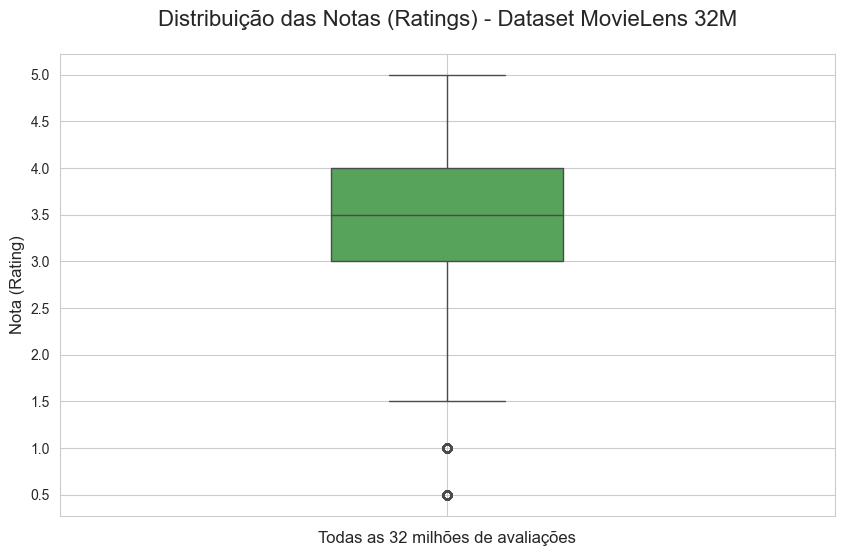


---

**📊 Análise Estatística da Distribuição**

A tabela abaixo complementa o box plot, mostrando os valores numéricos exatos da **média**, **mediana (50%)**, **desvio padrão** e **quartis** da distribuição das notas.

```
count    3.200020e+07
mean     3.540396e+00
std      1.058986e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
```


In [4]:
# --- CÉLULA 04: ANÁLISE VISUAL - DISTRIBUIÇÃO DAS NOTAS (RATINGS) ---

# 1. CONFIGURAÇÃO DO ESTILO VISUAL
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))  # Largura ampliada para melhor visualização

# 2. CRIAÇÃO DO BOX PLOT
sns.boxplot(y=ratings_df['rating'], color='#4CAF50', width=0.3)

# 3. TÍTULOS E RÓTULOS
plt.title('Distribuição das Notas (Ratings) - Dataset MovieLens 32M', fontsize=16, pad=20)
plt.ylabel('Nota (Rating)', fontsize=12)
plt.xlabel('Todas as 32 milhões de avaliações', fontsize=12)
plt.yticks(np.arange(0.5, 5.5, 0.5))
plt.grid(axis='x')  # Mostra apenas linhas verticais

plt.show()

# 4. ANÁLISE ESTATÍSTICA COMPLEMENTAR
stats_string = ratings_df['rating'].describe().to_string()

output_markdown = f"""
---

**📊 Análise Estatística da Distribuição**

A tabela abaixo complementa o box plot, mostrando os valores numéricos exatos da **média**, **mediana (50%)**, **desvio padrão** e **quartis** da distribuição das notas.

```
{stats_string}
```
"""
display(Markdown(output_markdown))

## 5️⃣ Treinamento Final do Modelo (SVD)

Após a etapa de validação, o modelo é treinado novamente — agora utilizando **100% do dataset** — para obter sua versão final e funcional.  
Essa etapa consolida o aprendizado de todas as interações disponíveis, garantindo maior precisão nas previsões.

Durante o processo, o algoritmo **SVD** é reinstanciado e treinado do zero com os mesmos hiperparâmetros validados anteriormente.  
Isso assegura que o modelo esteja em um **estado limpo e reproduzível**.

### Objetivos do Treinamento Final
1. **Aprendizado máximo:** O modelo utiliza toda a base de dados, ampliando sua capacidade de generalização.  
2. **Preparação para Previsões:** O treinamento completo cria os mapeamentos necessários para o uso da função `predict(user_id, item_id)`.

Essa etapa marca o momento em que o modelo passa de um protótipo avaliado para uma **versão de produção**, pronta para ser integrada à aplicação de recomendação.

---


In [5]:
# --- CÉLULA 05: TREINAMENTO FINAL DO MODELO SVD ---

# 1. PREPARAÇÃO DO DATASET COMPLETO PARA TREINAMENTO
display(Markdown("*Preparando o dataset completo para o treinamento final...*"))
final_trainset = data.build_full_trainset()

# 2. REINSTANCIAÇÃO E TREINAMENTO DO MODELO
display(Markdown("**Iniciando o treinamento do modelo SVD com 100% dos dados...** *(Esta etapa pode levar alguns minutos)*"))

start_time_fit = time.time()

# Reinstancia o modelo para garantir um estado limpo e reprodutível
algo = SVD(n_factors=100, n_epochs=70, random_state=42)

# Treinamento completo
algo.fit(final_trainset)

end_time_fit = time.time()
total_time_fit = end_time_fit - start_time_fit

# 3. SAÍDA FORMATADA (COMPATÍVEL COM GITHUB)
success_output = f"""
---

**🟢 Modelo Final Treinado com Sucesso!**

O algoritmo **SVD** foi treinado utilizando **100% do dataset**, estando agora pronto para realizar previsões por meio da função `.predict()`.

- **Tempo de Treinamento:** `{total_time_fit:.2f}` segundos (`{total_time_fit/60:.2f}` minutos)

---
"""

display(Markdown(success_output))


*Preparando o dataset completo para o treinamento final...*

**Iniciando o treinamento do modelo SVD com 100% dos dados...** *(Esta etapa pode levar alguns minutos)*


---

**🟢 Modelo Final Treinado com Sucesso!**

O algoritmo **SVD** foi treinado utilizando **100% do dataset**, estando agora pronto para realizar previsões por meio da função `.predict()`.

- **Tempo de Treinamento:** `622.86` segundos (`10.38` minutos)

---


## 6️⃣ Carregamento de Metadados (Títulos e Gêneros)

Após o treinamento do modelo, as previsões retornam apenas o `item_id`.  
Para tornar as recomendações compreensíveis e contextualizadas, é necessário mapear esses identificadores para seus **títulos** e **gêneros** correspondentes.

Esta etapa carrega o arquivo `movies.csv`, que contém os metadados dos filmes, e constrói **duas tabelas de mapeamento** (*lookup tables*):

- **`id_to_titulo`** → Mapeia cada `item_id` para seu respectivo título.  
- **`id_to_generos`** → Mapeia cada `item_id` para os gêneros associados.

Esses dicionários serão utilizados nas próximas etapas para enriquecer as previsões e compor o pacote final do modelo que será consumido pelo `app.py`.

---


In [6]:
# --- CÉLULA 06: CARREGAMENTO DE METADADOS (movies.csv) ---

file_path_item = '../dados/ml-32m/movies.csv'
display(Markdown(f"*Carregando metadados de `{file_path_item}`...*"))

try:
    # Leitura do arquivo com colunas relevantes
    items_df = pd.read_csv(
        file_path_item,
        sep=',',
        encoding='utf-8',
        usecols=['movieId', 'title', 'genres']
    )

    # Renomear colunas e converter tipos
    items_df.columns = ['item_id', 'titulo_topico', 'generos']
    items_df['item_id'] = items_df['item_id'].astype(str)

    # Criar dicionários de mapeamento
    id_to_titulo = items_df.set_index('item_id')['titulo_topico'].to_dict()
    id_to_generos = items_df.set_index('item_id')['generos'].to_dict()

    # Saída de sucesso
    total_mapeado = len(id_to_titulo)
    exemplo_titulo = id_to_titulo.get('1', 'N/A')
    exemplo_generos = id_to_generos.get('1', 'N/A')

    success_output = f"""
---

**🟢 Mapeamentos de Metadados Carregados!**

- **Total de Itens Mapeados:** `{total_mapeado:,}`

---

**Exemplo de Validação**
- **ID:** `1`
- **Título:** *{exemplo_titulo}*
- **Gêneros:** *{exemplo_generos}*

---
"""
    display(Markdown(success_output))

except FileNotFoundError:
    error_output = f"""
---

**🔴 **ERRO CRÍTICO:** O arquivo `movies.csv` não foi encontrado.**  
Verifique se o caminho está correto.

📂 **Caminho buscado:** `{file_path_item}`

---
"""
    display(Markdown(error_output))

except Exception as e:
    error_output = f"""
---

**🔴 **ERRO INESPERADO:** Falha ao carregar ou processar `movies.csv`.**  
💬 **Detalhes do erro:** `{e}`

---
"""
    display(Markdown(error_output))


*Carregando metadados de `../dados/ml-32m/movies.csv`...*


---

**🟢 Mapeamentos de Metadados Carregados!**

- **Total de Itens Mapeados:** `87,585`

---

**Exemplo de Validação**
- **ID:** `1`
- **Título:** *Toy Story (1995)*
- **Gêneros:** *Adventure|Animation|Children|Comedy|Fantasy*

---


## 7️⃣ Prova de Robustez — Previsões para um “Usuário Frio”

Um dos testes mais importantes em sistemas de recomendação é verificar o desempenho do modelo com **usuários frios** (*cold start users*) — aqueles com poucas ou nenhuma interação registrada.

Um modelo ineficiente tenderia a prever sempre a **mesma nota média global**, sem distinguir as características individuais de cada item.

Nesta célula, avaliamos o modelo **SVD treinado na base completa** gerando previsões para o `user_id = '1'`, um usuário real do dataset **MovieLens 32M**.

As previsões são comparadas entre diferentes itens.  
Se houver **variação significativa nas notas previstas**, isso comprova que o modelo aprendeu **fatores latentes reais** — ou seja, está personalizando as recomendações de forma inteligente e sensível ao contexto.

---


In [7]:
# --- CÉLULA 07: PROVA DE ROBUSTEZ - PREVISÕES PARA USUÁRIO FRIO ---

# 1. Definir o ID do usuário e a lista de itens para teste
user_id_teste = '1'
item_ids_teste = ['120', '240', '360', '589', '296']

# 2. Apresentação inicial
display(Markdown(f"**🔮 Previsões de Afinidade para o Usuário `{user_id_teste}`**"))

# 3. Geração das previsões
results_list = []
for item_id in item_ids_teste:
    titulo = id_to_titulo.get(item_id, f"ID {item_id} (Título Desconhecido)")
    previsao = algo.predict(user_id_teste, item_id)
    results_list.append({'Título do Tópico': titulo, 'Nota Prevista': previsao.est})

# 4. Criação da tabela de resultados
results_df = pd.DataFrame(results_list)
results_df['Nota Prevista'] = results_df['Nota Prevista'].map('{:.4f}'.format)
results_table = results_df.to_markdown(index=False)

# 5. Comentário analítico final
final_note = (
    "\n\n*__Nota:__ A variação nas notas previstas demonstra que o modelo está "
    "fazendo previsões personalizadas com base nas características de cada item, "
    "e não apenas utilizando uma média global.*"
)

# 6. Exibição formatada da tabela e da análise
display(Markdown(results_table + final_note))


**🔮 Previsões de Afinidade para o Usuário `1`**

| Título do Tópico                  |   Nota Prevista |
|:----------------------------------|----------------:|
| Race the Sun (1996)               |          3.7883 |
| Hideaway (1995)                   |          1.9321 |
| I Love Trouble (1994)             |          1.7566 |
| Terminator 2: Judgment Day (1991) |          5      |
| Pulp Fiction (1994)               |          3.9837 |

*__Nota:__ A variação nas notas previstas demonstra que o modelo está fazendo previsões personalizadas com base nas características de cada item, e não apenas utilizando uma média global.*

## 8️⃣ Teste de Previsão para um "Usuário Ativo"

Como contraponto ao teste anterior, agora verificamos as previsões para um **usuário ativo** (`user_id='1000'`), alguém com um histórico de avaliações mais extenso no dataset.

Para um usuário com mais dados, esperamos que o modelo **SVD** tenha aprendido suas preferências de forma mais precisa.  
As previsões devem refletir um **perfil de afinidade claro**, com notas estimadas mais altas para itens alinhados ao seu gosto e mais baixas para outros.

O objetivo é confirmar que as notas previstas são **consistentes com um perfil de gosto específico**, validando a capacidade de **personalização e diferenciação individual** do modelo.

---


In [8]:
# --- CÉLULA 08: TESTE DE PREVISÃO PARA USUÁRIO ATIVO ---

# 1. Definir o ID do usuário ativo e lista de itens
user_id_teste_ativo = '1000'
item_ids_teste = ['120', '240', '360', '589', '296']

# 2. Apresentação inicial
display(Markdown(f"**🔮 Previsões de Afinidade para o Usuário `{user_id_teste_ativo}` (Usuário Ativo)**"))

# 3. Geração das previsões
results_list_ativo = []
for item_id in item_ids_teste:
    titulo = id_to_titulo.get(item_id, f"ID {item_id} (Título Desconhecido)")
    previsao = algo.predict(user_id_teste_ativo, item_id)
    results_list_ativo.append({'Título do Tópico': titulo, 'Nota Prevista': previsao.est})

# 4. Montagem e formatação da tabela
results_df_ativo = pd.DataFrame(results_list_ativo)
results_df_ativo['Nota Prevista'] = results_df_ativo['Nota Prevista'].map('{:.4f}'.format)
results_table_ativo = results_df_ativo.to_markdown(index=False)

# 5. Comentário analítico
final_note_ativo = (
    "\n\n*__Nota:__ A variação nas previsões reflete o perfil de gosto específico "
    "que o modelo aprendeu para este usuário ativo, demonstrando sua capacidade "
    "de personalização e diferenciação individualizada.*"
)

# 6. Exibição do resultado final formatado
display(Markdown(results_table_ativo + final_note_ativo))


**🔮 Previsões de Afinidade para o Usuário `1000` (Usuário Ativo)**

| Título do Tópico                  |   Nota Prevista |
|:----------------------------------|----------------:|
| Race the Sun (1996)               |          2.9788 |
| Hideaway (1995)                   |          3.2769 |
| I Love Trouble (1994)             |          3.7103 |
| Terminator 2: Judgment Day (1991) |          3.9577 |
| Pulp Fiction (1994)               |          3.3966 |

*__Nota:__ A variação nas previsões reflete o perfil de gosto específico que o modelo aprendeu para este usuário ativo, demonstrando sua capacidade de personalização e diferenciação individualizada.*

## 9️⃣ Exportação do Modelo para Produção

Finalmente, salvamos o modelo treinado (`algo`) e os dicionários de mapeamento em um único arquivo `.pkl` usando a biblioteca `pickle`.

Este arquivo é o **produto final** do notebook — ele reúne:

- O modelo SVD treinado.  
- Os mapeamentos de títulos (`id_to_titulo`).  
- Os mapeamentos de gêneros (`id_to_generos`).  

O resultado é um artefato único (`svd_model_data.pkl`) que pode ser carregado diretamente pelo aplicativo **Streamlit (`app.py`)**, permitindo que o sistema de recomendação funcione de forma imediata — **sem a necessidade de retreinar o modelo** a cada execução.

---


In [9]:
# --- CÉLULA 09: SALVANDO O MODELO FINAL PARA O APP ---

# Agrupa todos os objetos necessários para o app em um único dicionário
model_data = {
    'model': algo,
    'id_to_titulo': id_to_titulo,
    'id_to_generos': id_to_generos
}

# Define o caminho de destino do arquivo
output_path = '../svd_model_data.pkl'

# Salva o dicionário em um arquivo binário .pkl
with open(output_path, 'wb') as f:
    pickle.dump(model_data, f)

# --- SAÍDA FINAL FORMATADA ---
final_output = f"""
**🏁 Notebook Concluído: Artefato Exportado com Sucesso!**

O modelo **SVD treinado** e os **mapas de metadados** foram agrupados e salvos no arquivo abaixo:

- **Arquivo Gerado:** `{output_path}`

---

🧠 Este arquivo é o *"cérebro"* do sistema de recomendação  
e contém tudo o que é necessário para a aplicação interativa.

---

**Próximo Passo:**  
Use este arquivo no seu aplicativo **Streamlit (`app.py`)**  
para carregar o modelo pré-treinado e gerar recomendações ao vivo.
"""
display(Markdown(final_output))



**🏁 Notebook Concluído: Artefato Exportado com Sucesso!**

O modelo **SVD treinado** e os **mapas de metadados** foram agrupados e salvos no arquivo abaixo:

- **Arquivo Gerado:** `../svd_model_data.pkl`

---

🧠 Este arquivo é o *"cérebro"* do sistema de recomendação  
e contém tudo o que é necessário para a aplicação interativa.

---

**Próximo Passo:**  
Use este arquivo no seu aplicativo **Streamlit (`app.py`)**  
para carregar o modelo pré-treinado e gerar recomendações ao vivo.
